In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import seaborn as sns
from statsmodels.tsa import stattools
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from time import time

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\pmdarima\__init__.py:107: UserWarning: pmdarima support for 32-bit systems is ending with Python 3.10.Your system is not guaranteed to work going forward
  _warnings.warn(


## Datenbank einbinden
* Temperatursensor 1

In [2]:
connection = sql.connect("gcs_gh_10012022.db")

query_params = ['''SELECT * FROM s1_temp''']
df_temp1 = pd.read_sql_query(query_params[0], connection, parse_dates=['timestamp'], index_col=['timestamp'])

In [3]:
print(df_temp1.sort_index().loc['2021-06-05 00:00:00':'2021-06-06 00:00:00'])
# pro Tag 273/274 Datenpunkte

                        value
timestamp                    
2021-06-05 00:04:18  20.90105
2021-06-05 00:09:18  20.84497
2021-06-05 00:14:18  20.75951
2021-06-05 00:19:18  20.71946
2021-06-05 00:24:18  20.67673
...                       ...
2021-06-05 23:35:07  22.71152
2021-06-05 23:40:07  22.65545
2021-06-05 23:45:07  22.57000
2021-06-05 23:50:07  22.55665
2021-06-05 23:55:07  22.51392

[273 rows x 1 columns]


## Ausreißer behandeln
Ausreißer werden mit der Interquartile Range (IQR) herausgefiltert. Dabei werden Werte, die über dem 1.5-fachen des 0.75-Quantils (oberes Quantil) oder unter dem 1.5-fachen des 0.25-Quantils (unteres Quantil) liegen mit dem Monatsmittelwert ersetzt

In [4]:
def outliers(s, replace=np.nan):
    Q1, Q3 = np.percentile(s, [25 ,75])
    IQR = Q3-Q1
    return s.where((s > (Q1 - 1.5 * IQR)) & (s < (Q3 + 1.5 * IQR)), replace)

In [5]:
df_temp1['month'] = df_temp1.index.month
df_temp1_clean = df_temp1.groupby('month')['value'].apply(outliers)
df_temp1_clean = pd.DataFrame(df_temp1_clean)
df_temp1_clean = df_temp1_clean.fillna(df_temp1_clean.groupby(df_temp1_clean.index.month).transform('mean'))

## Daten zusammenfassen

Die Temperaturdaten werden zu stündlichen Temperaturdaten zusammengefasst und fehlende Werte durch einen forward-fill aufgefüllt. Es wird der Zeitraum Sommer 2021 gewählt, um jährliche Saisonalität auszuschließen.

In [6]:
df_temp1_hourly = df_temp1_clean.resample('H').mean()

df_temp1_hourly = df_temp1_hourly.sort_index().loc['2021-06-01':'2021-08-31']
print(df_temp1_hourly)

                         value
timestamp                     
2021-06-01 00:00:00  18.621068
2021-06-01 01:00:00  17.810807
2021-06-01 02:00:00  17.165013
2021-06-01 03:00:00  16.813985
2021-06-01 04:00:00  16.446268
...                        ...
2021-08-31 19:00:00  20.368094
2021-08-31 20:00:00  19.398623
2021-08-31 21:00:00  19.108042
2021-08-31 22:00:00  18.321507
2021-08-31 23:00:00  17.727725

[2208 rows x 1 columns]


## Stationarität
Die Stationarität wird von den Zeitreihenmodellen, die im Folgenden verwendet werden, vorausgesetzt. 

<b> Stationarität: </b>
* mittelwertstationär, konstanter Mittelwert μ
* varianzstationär, konstante Varianz σ
* kovarianzstationär

### Prüfen der Stationarität

                         value
timestamp                     
2021-06-01 00:00:00  18.621068
2021-06-01 01:00:00  17.810807
2021-06-01 02:00:00  17.165013
2021-06-01 03:00:00  16.813985
2021-06-01 04:00:00  16.446268
...                        ...
2021-08-31 19:00:00  20.368094
2021-08-31 20:00:00  19.398623
2021-08-31 21:00:00  19.108042
2021-08-31 22:00:00  18.321507
2021-08-31 23:00:00  17.727725

[2208 rows x 1 columns]


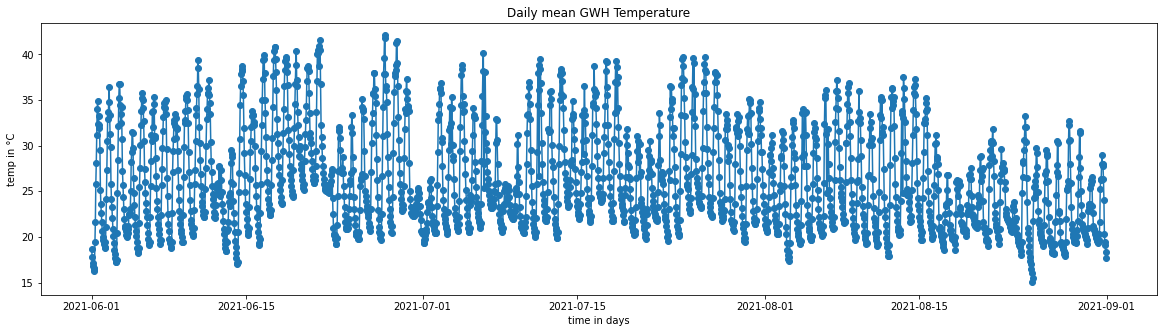

In [7]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(df_temp1_hourly.index, df_temp1_hourly['value'])
ax.plot(df_temp1_hourly.index, df_temp1_hourly['value'])
ax.set(xlabel="time in days",
       ylabel="temp in °C",
       title="Daily mean GWH Temperature")
print(df_temp1_hourly)

<b>Statistischer Test:</b> <br>
Durch den Augmented-Dickey-Fuller-Test geprüft, ob die Tempereaturdaten stationär sind. <br>
<p>Nullhypothese H0: Φ => 1 → Einheitswurzel vorhanden, Zeitreihe ist nicht stationär <br>
Alternativhypthese H1: Φ < 1 → Zeitreihe ist stationär

Liegt der p-Wert unter der Schwelle von 5% (p < 0.05) kann mit 95% Sicherheit gesagt werden, dass die Zeitreihe stationär ist.

In [8]:
series = df_temp1_hourly['value'].values
result = adfuller(series)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -4.060323998666195
p-value: 0.0011255751387953688
Critial Values:
   1%, -3.4333532186762805
Critial Values:
   5%, -2.862866720471125
Critial Values:
   10%, -2.5674762791431696


Da (p-Wert) 0.0011 < (p-Wert Schwelle) 0.05 , wird die Nullhyppthese abgelehnt. Die Zeitreihe ist stationär. <br>

## Stationarität herstellen

### Saisonalität entfernen

Die Zeitreihe ist nach dem ADF-Test zwar stationär, allerdings scheint noch eine Saisonalität vorzuliegen. Da angenommen wird, dass sich die Temperatur im Tagesrhythmus verändert, wird die Differenz von 24 gebildet. d.h. die Zeitreihe wird mit ihrer, um 24h verschobenen, Zeitreihe abgezogen. Um die Varianzen zu reduzieren wird das Ergbnis nochmal um 1 differenziert.

                        value
timestamp                    
2021-06-01 00:00:00       NaN
2021-06-01 01:00:00       NaN
2021-06-01 02:00:00       NaN
2021-06-01 03:00:00       NaN
2021-06-01 04:00:00       NaN
...                       ...
2021-08-31 19:00:00 -2.307852
2021-08-31 20:00:00 -0.630584
2021-08-31 21:00:00 -0.145508
2021-08-31 22:00:00 -0.593927
2021-08-31 23:00:00 -0.407428

[2208 rows x 1 columns]


[Text(0.5, 0, 'time in days'),
 Text(0, 0.5, 'temp in °C'),
 Text(0.5, 1.0, 'Detrended GWH Temperature')]

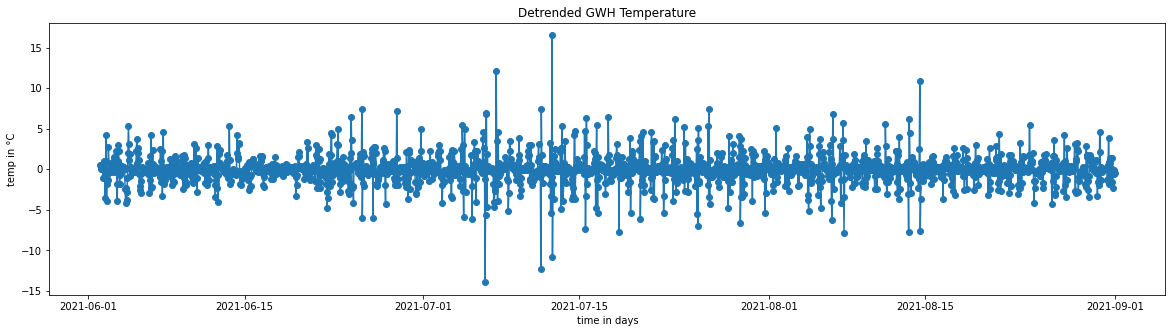

In [9]:
series_temp1_stationary_diff = df_temp1_hourly['value'].diff(periods=24)
series_temp1_stationary_diff = series_temp1_stationary_diff -series_temp1_stationary_diff.shift(1)
df_temp1_detrend = pd.DataFrame(series_temp1_stationary_diff)
df_temp1_detrend.columns.values[0] = "value"
print(df_temp1_detrend)

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_temp1_detrend.index, df_temp1_detrend['value'])
ax.scatter(df_temp1_detrend.index, df_temp1_detrend['value'])
ax.set(xlabel="time in days",
       ylabel="temp in °C",
       title="Detrended GWH Temperature")

In [10]:
df_temp1_detrend.isnull().values.any()
df_temp1_detrend = df_temp1_detrend.fillna(method='bfill')

series = df_temp1_detrend
result = adfuller(series, autolag='AIC')

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -14.867136955259868
p-value: 1.6847890618418885e-27
Critial Values:
   1%, -3.4333518400589074
Critial Values:
   5%, -2.8628661117509484
Critial Values:
   10%, -2.567475955039574


In [11]:
df_clean = df_temp1_detrend['value']

## Dekompostion in Trend-, Saisonalitäts-, Restkomponente
Das Modul statsmodels stellt eine Methode zur Verfügung, bei der die Komponenten automatisch berechnet werden durch die Moving-Average-Methode.

Da kein steigender Trend und keine sich mit dem Trend veränderte Saisonalität oder Restkomponente feststellen lässt, wird angenommen, dass die Zeitreihe sich durch ein additives Model beschreiben lässt.

Eine Zeitreihe besteht somimt aus:  Trendkomponente + Saisonkomponente + Restkomponente → Yt = Tt + St + et

Es werden die Trend- und Saisonalkomponente von der ursprünglichen Zeitreihe abgezogen, sodass die Restkomponente zurückbleibt. Bei der Restkomponente handelt es sich um die stationäre Zeitreihe.

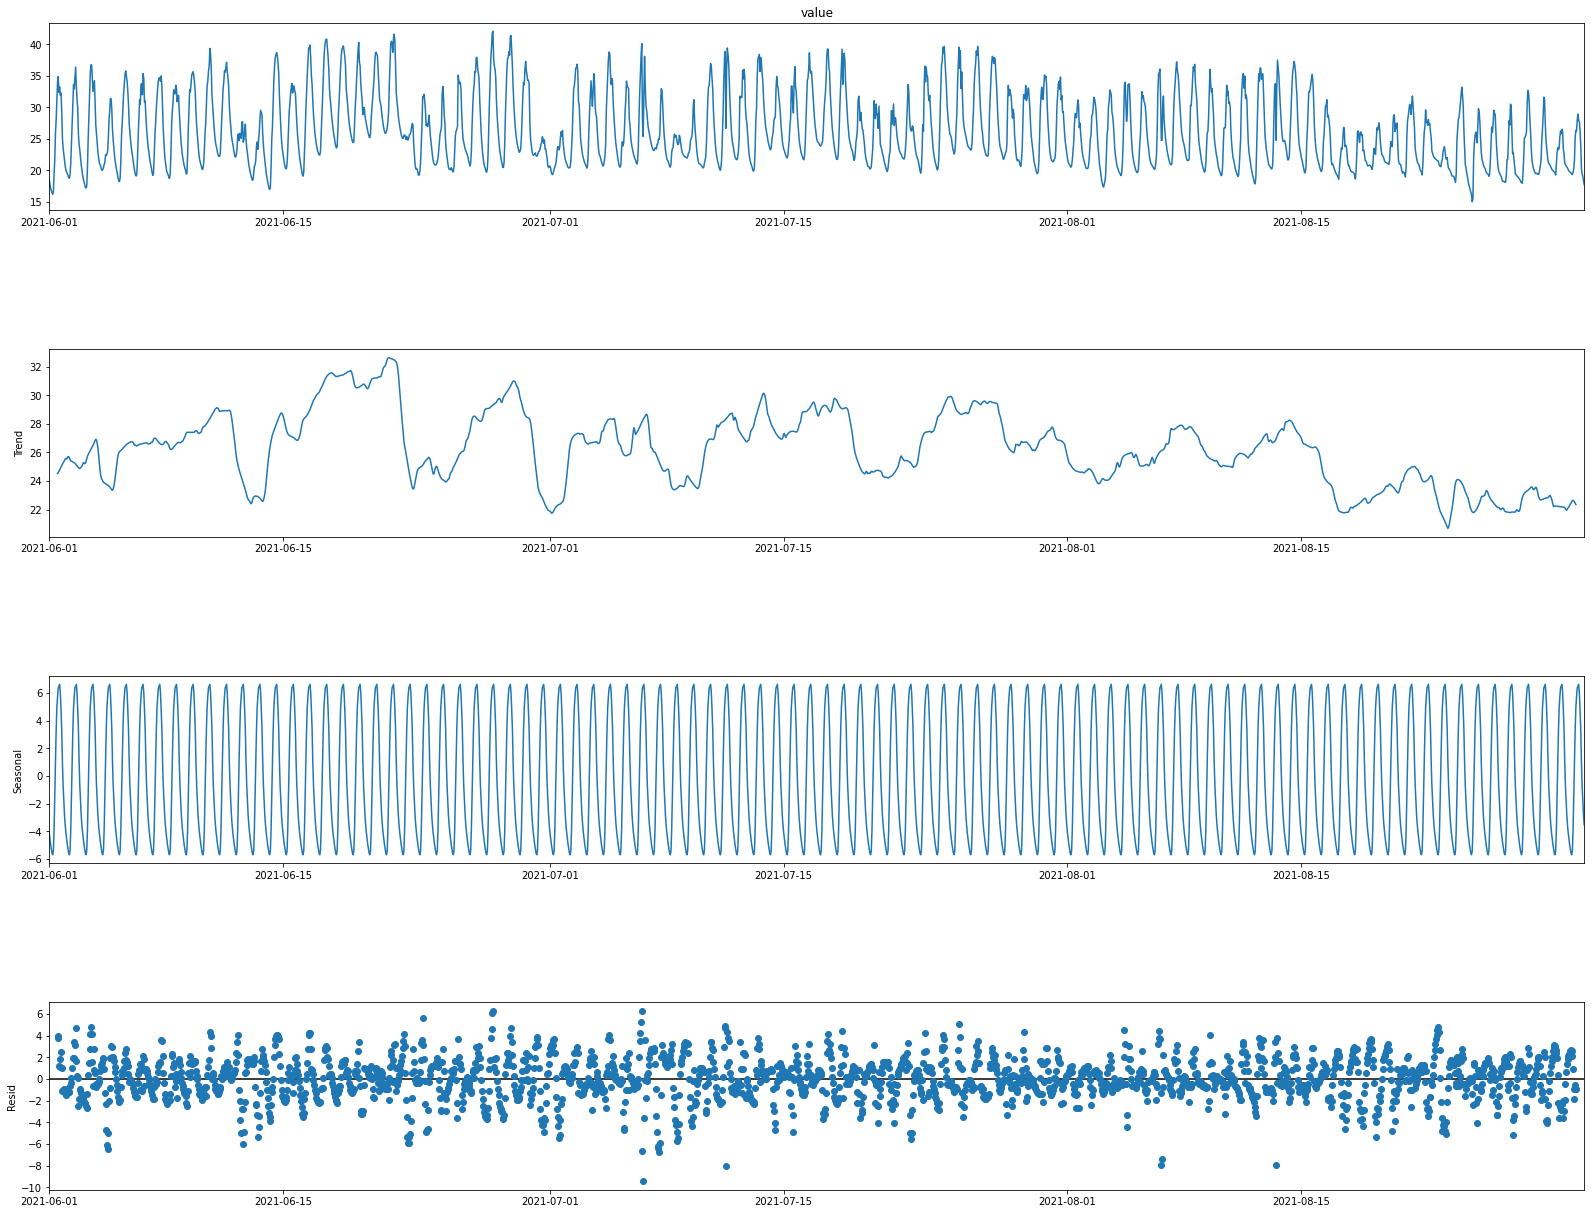

In [12]:
decomp_result = seasonal_decompose(df_temp1_hourly['value'], model='additive')

trend = decomp_result.trend
periodic = decomp_result.seasonal
residual = decomp_result.resid

fig = decomp_result.plot()
fig.set_size_inches((25, 20))

## Autocorrelation

### ACF und PACF mit stationären Daten

<b>ACF</b> 

Die ACF gibt an wie groß der Zusammenhang zwischen dem aktuellen Wert und vergangenen Werten ist. <br>
Aus dem ACF-Plot kann die Ordnung des MA-Modells geschätzt werden.

<b>ACF für tägliche Daten:</b>

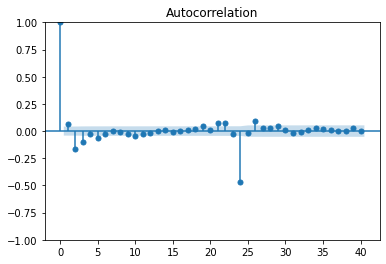

In [13]:
acf_result = stattools.acf(df_clean)
acf_plot_temp1_hourly = tsaplots.plot_acf(df_clean, lags=40)

Ab einem Lag von 3 befindet sich die ACF innerhalb des Signifikanzbandes, d.h. die MA-Ordnung kann bis zu 3 betragen. 

<b>PACF</b> 

Die PACF gibt an wie groß der Zusammenhang zwischen Werten ist, die nicht durch die dazwischenliegenden Lags erklärt wird.<br>
Aus dem PACF-Plot kann die Ordnung des AR-Modells geschätzt werden

<b>PACF für tägliche Daten:</b>

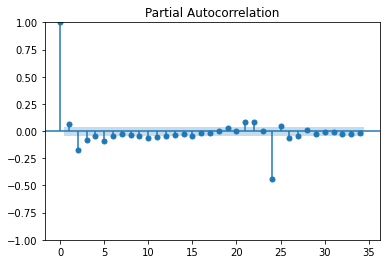

In [14]:
pacf_plot_temp1_hourly = tsaplots.plot_pacf(df_clean,  method='ywm')

Ab einem Lag von 5 befindet sich die ACF innerhalb des Signifikanzbandes, d.h. die Ordnung kann bis zu 5 betragen. 

## AR(I)MA-Modell

Das AR(I)MA-Modell ist wie folgt aufgebaut: AR(I)MA(p,d,q)

   * p: AR-Ordnung
   * d: Anzahl der Differenzierung
   * q: MA-Ordnung

In [15]:
# Frequenz der Zeitreihe wird festgelegt
df_clean = df_clean.asfreq(pd.infer_freq(df_clean.index))

In [16]:
# Für die Evaluation: Training-Set, Testing-Set bilden
train_end = datetime.datetime(2021,8,28)
test_end = datetime.datetime(2021,8,31)

train_data = df_clean[:train_end]
test_data = df_clean[train_end + timedelta(days=1):test_end]

print(train_data)

timestamp
2021-06-01 00:00:00    0.496555
2021-06-01 01:00:00    0.496555
2021-06-01 02:00:00    0.496555
2021-06-01 03:00:00    0.496555
2021-06-01 04:00:00    0.496555
                         ...   
2021-08-27 20:00:00   -0.359584
2021-08-27 21:00:00    0.082075
2021-08-27 22:00:00    0.172922
2021-08-27 23:00:00    0.092790
2021-08-28 00:00:00    0.076655
Freq: H, Name: value, Length: 2113, dtype: float64


In [17]:
# ARIMA-Model fitten, AR = 2, I =0, MA = 5
model = ARIMA(train_data, order=(3,0,4))
start = time()
model_fit = model.fit()
end = time()
print('Model fitting time:', end - start)

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model fitting time: 8.14673376083374


In [18]:
# Zusammenfassung des Modells
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 2113
Model:                 ARIMA(3, 0, 4)   Log Likelihood               -4072.238
Date:                Mon, 30 May 2022   AIC                           8162.476
Time:                        16:27:37   BIC                           8213.379
Sample:                    06-01-2021   HQIC                          8181.115
                         - 08-28-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.443      0.658      -0.001       0.002
ar.L1         -0.1209      0.016     -7.483      0.000      -0.153      -0.089
ar.L2         -0.1566      0.012    -13.159      0.0

In [19]:
# Prediction Start und Ende festlegen
pred_start = test_data.index[0]
pred_end =test_data.index[-1]

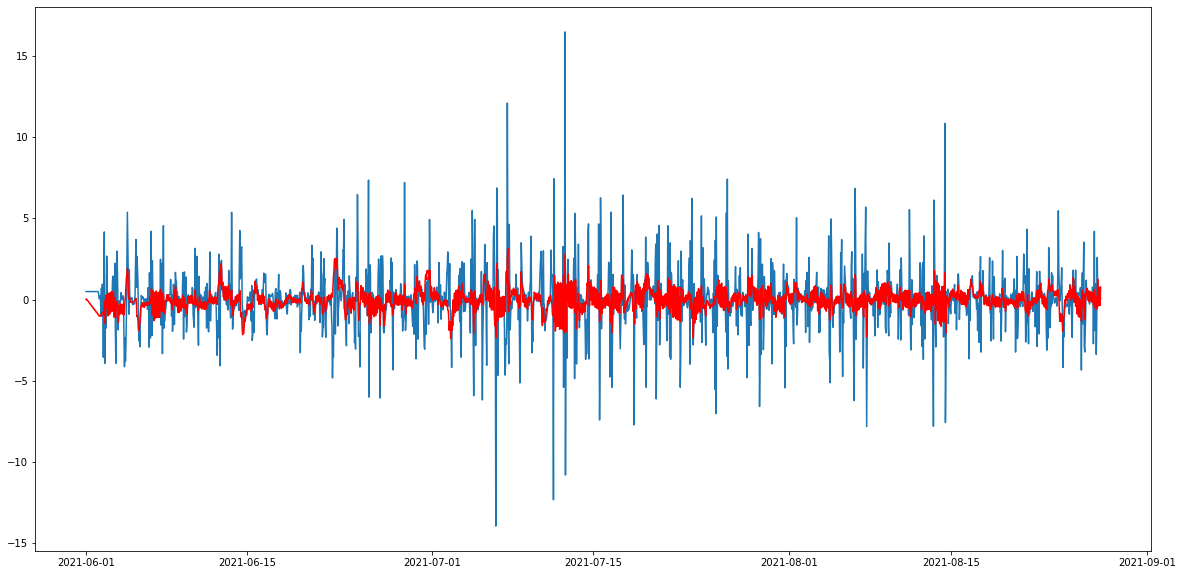

In [20]:
# Predictions und Reste, die das Modell nicht erklären konnte in einer Variablen speichern
predictions = model_fit.predict(start=pred_start, end=pred_end)
plt.figure(figsize=(20,10))
plt.plot(train_data)
plt.plot(model_fit.fittedvalues, color='red')

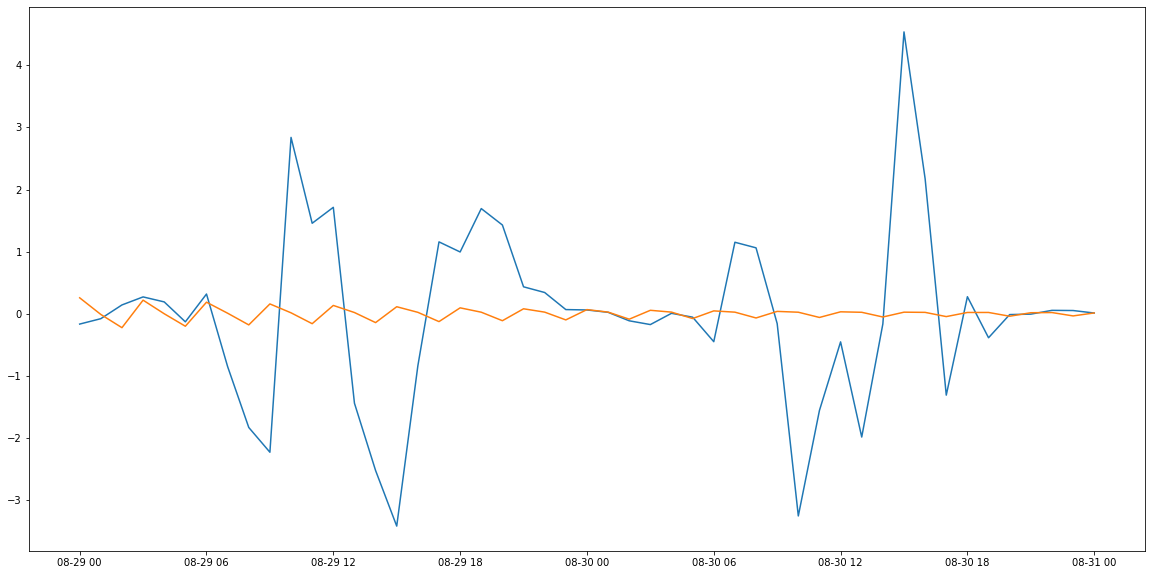

In [21]:
# Testdaten und dazugehörigen Predictions plotten
plt.figure(figsize=(20,10))
plt.plot(test_data)
plt.plot(predictions)

# SARIMA

In [22]:
df_clean = df_clean.sort_index().loc['2021-08-24 00:00:00':'2021-08-31 00:00:00']

In [23]:
# SARIMA-Modell fitten
stepwise_fit = auto_arima(df_clean, start_p = 0, start_q = 0,
                            test='adf',
                            max_p = 3, max_q = 3, 
                            m=24,
                            d=0,
                            seasonal=True,
                            start_P=0, start_Q=0,
                            D=0,
                            error_action='ignore',  # ignoriert Ordnungen, die nicht funktionieren
                            suppress_warnings=True,  # ignoriert Konvergenzwarnungen
                            stepwise=True)

MemoryError: Unable to allocate 3.37 MiB for an array with shape (51, 51, 170) and data type float64

In [ ]:
stepwise_fit.summary()

model = SARIMAX(df_clean, order=(3,1,0), seasonal_order=(0,0,1,24))
model_fit = model.fit()
predictions = model_fit.predict(start=pred_start, end=pred_end)

plt.figure(figsize=(10,20))
plt.subplot(411)
plt.plot(test_data, label='Trend of time series',color='#003049')
plt.plot(predictions, label='Trend of time series',color='#f77f00')

print(test_data)
